In [1]:
import os
os.chdir('/home/renwh/gaze/renwh/caffe_with_cudnnv3/')

import sys
sys.path.insert(0,'./python')
import caffe

from pylab import *
%matplotlib inline


caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/mymodel/01/lenet_solver.prototxt')

In [2]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1000, 1, 36, 60)),
 ('label', (1000, 6)),
 ('gaze', (1000, 3)),
 ('headpose', (1000, 3)),
 ('conv1', (1000, 20, 32, 56)),
 ('pool1', (1000, 20, 16, 28)),
 ('conv2', (1000, 50, 12, 24)),
 ('pool2', (1000, 50, 6, 12)),
 ('ip1', (1000, 500)),
 ('ip2', (1000, 50)),
 ('cat', (1000, 53)),
 ('ip3', (1000, 3)),
 ('loss', ())]

In [3]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('ip1', (500, 3600)),
 ('ip2', (50, 500)),
 ('ip3', (3, 53))]

In [4]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(0.527060329914093, dtype=float32)}

[[ -2.44513273e-01   5.20949736e-02  -9.68245506e-01  -5.07045567e-01
   -1.12138920e-01  -2.90884897e-02]
 [ -7.41908699e-02   2.27922529e-01  -9.70848620e-01  -1.28387764e-01
    1.65355857e-02   1.06296828e-03]
 [ -1.74087971e-01   3.04691344e-02  -9.84258592e-01  -9.52000245e-02
   -3.14195365e-01  -1.50917871e-02]
 [ -2.49744281e-02   1.77879885e-01  -9.83735263e-01  -7.38587156e-02
   -1.21144764e-02  -4.47588827e-04]
 [ -1.61419377e-01   5.79187945e-02  -9.85184848e-01  -1.06810793e-01
    1.42905980e-01   7.65229668e-03]
 [ -1.52415037e-01   2.09456533e-01  -9.65866268e-01  -5.29863574e-02
   -1.14266567e-01  -3.03129526e-03]
 [ -1.76816806e-02   6.62708879e-02  -9.97644961e-01  -6.35477304e-02
   -2.95568883e-01  -9.46362782e-03]
 [  1.79661021e-01   2.34958977e-01  -9.55257118e-01  -8.40480402e-02
    1.60711512e-01   6.77234307e-03]]


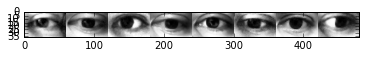

In [5]:
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(36, 8*60), cmap='gray')
print solver.net.blobs['label'].data[:8]

In [6]:
solver.step(1)

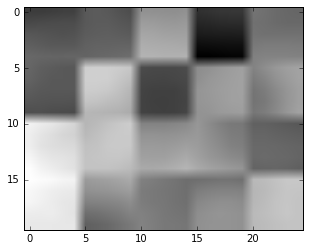

In [7]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

Show the conv1 weights pics.


Then, I will train the model, and log some information.

In [8]:
%%time
niter = 500
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
#test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 3))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip3'].data[:8]
    if it % test_interval == 0:
        print 'Iteration', it
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)

Iteration 0
Iteration 25
Iteration 50
Iteration 75
Iteration 100
Iteration 125
Iteration 150
Iteration 175
Iteration 200
Iteration 225
Iteration 250
Iteration 275
Iteration 300
Iteration 325
Iteration 350
Iteration 375
Iteration 400
Iteration 425
Iteration 450
Iteration 475
CPU times: user 32.7 s, sys: 5.03 s, total: 37.7 s
Wall time: 37.7 s


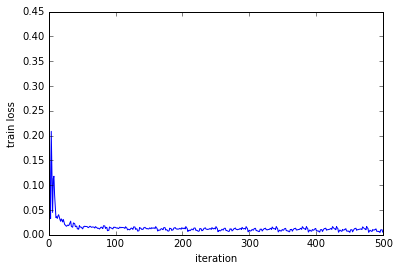

In [9]:
_, ax1 = subplots()
ax1.plot(arange(niter), train_loss)
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')

**show you the train loss curve.

--------------------------------------------------------------------------------------------------------------
1000 test pic, mean error is  5.0152960555 degree


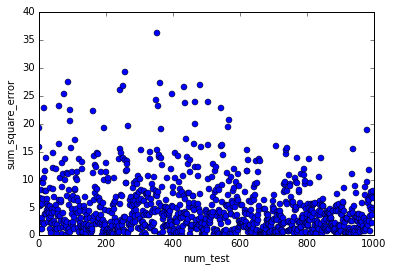

In [10]:
num_test = 1000
#figure(figsize=(10, 5))
#imshow(solver.test_nets[0].blobs['data'].data[:num_test, 0].transpose(1, 0, 2).reshape(36, num_test*60), cmap='gray')
    
# print the label and train result
#for i in range(num_test):
#    print solver.test_nets[0].blobs['label'].data[i,:3] ,'label<->ip3', solver.test_nets[0].blobs['ip3'].data[i]

print '--------------------------------------------------------------------------------------------------------------'
# caculate the square error for each gaze vector
sub_error = zeros((num_test, 3))
square_error = zeros((num_test, 3))
sum_square_error = zeros(num_test)
for i in range(num_test):
    sub_error[i,:] = np.subtract(solver.test_nets[0].blobs['label'].data[i,:3], solver.test_nets[0].blobs['ip3'].data[i])
    square_error = np.square(sub_error)
    sum_square_error = np.sum(square_error,1)
    #print sub_error[i,:],square_error[i,:],sum_square_error[i]
    #print sum_square_error[i],

print num_test,'test pic, mean error is ',np.sum(sum_square_error,0)/num_test*180,'degree'
_, ax1 = subplots()
ax1.plot(arange(num_test), sum_square_error*180,'bo', label='sampled')
ax1.set_xlabel('num_test')
ax1.set_ylabel('sum_square_error')
    

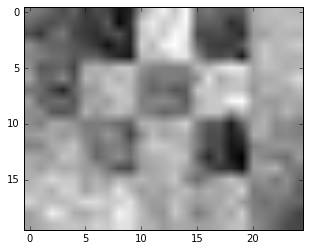

In [11]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

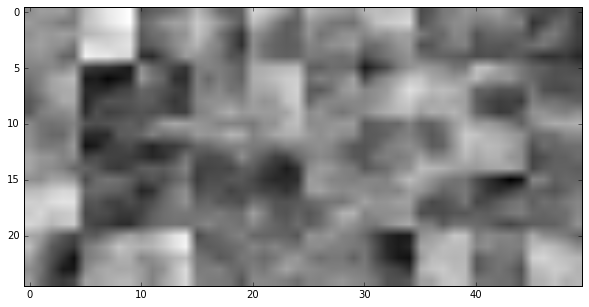

In [12]:
figure(figsize=(10, 5))
imshow(solver.net.params['conv2'][0].diff[:, 0].reshape(5, 10, 5, 5)
       .transpose(0, 2, 1, 3).reshape(5*5, 10*5), cmap='gray')

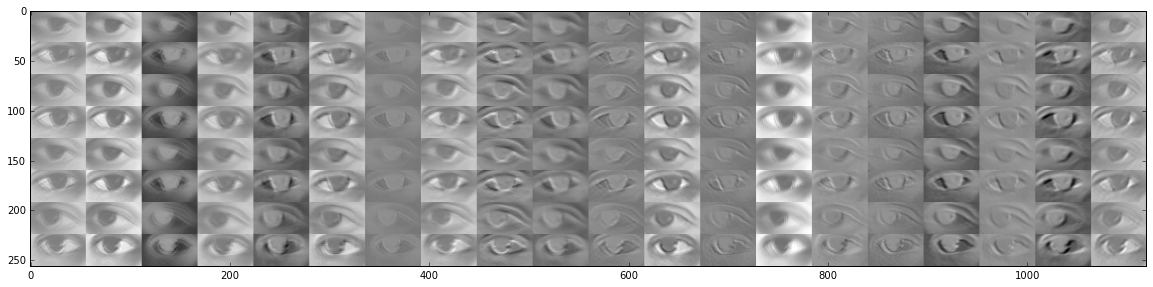

In [13]:
figure(figsize=(20, 10))
imshow(solver.test_nets[0].blobs['conv1'].data[:8, :].reshape(8,20,32,56)
           .transpose(0,2,1,3).reshape(8*32, 20*56), cmap='gray')

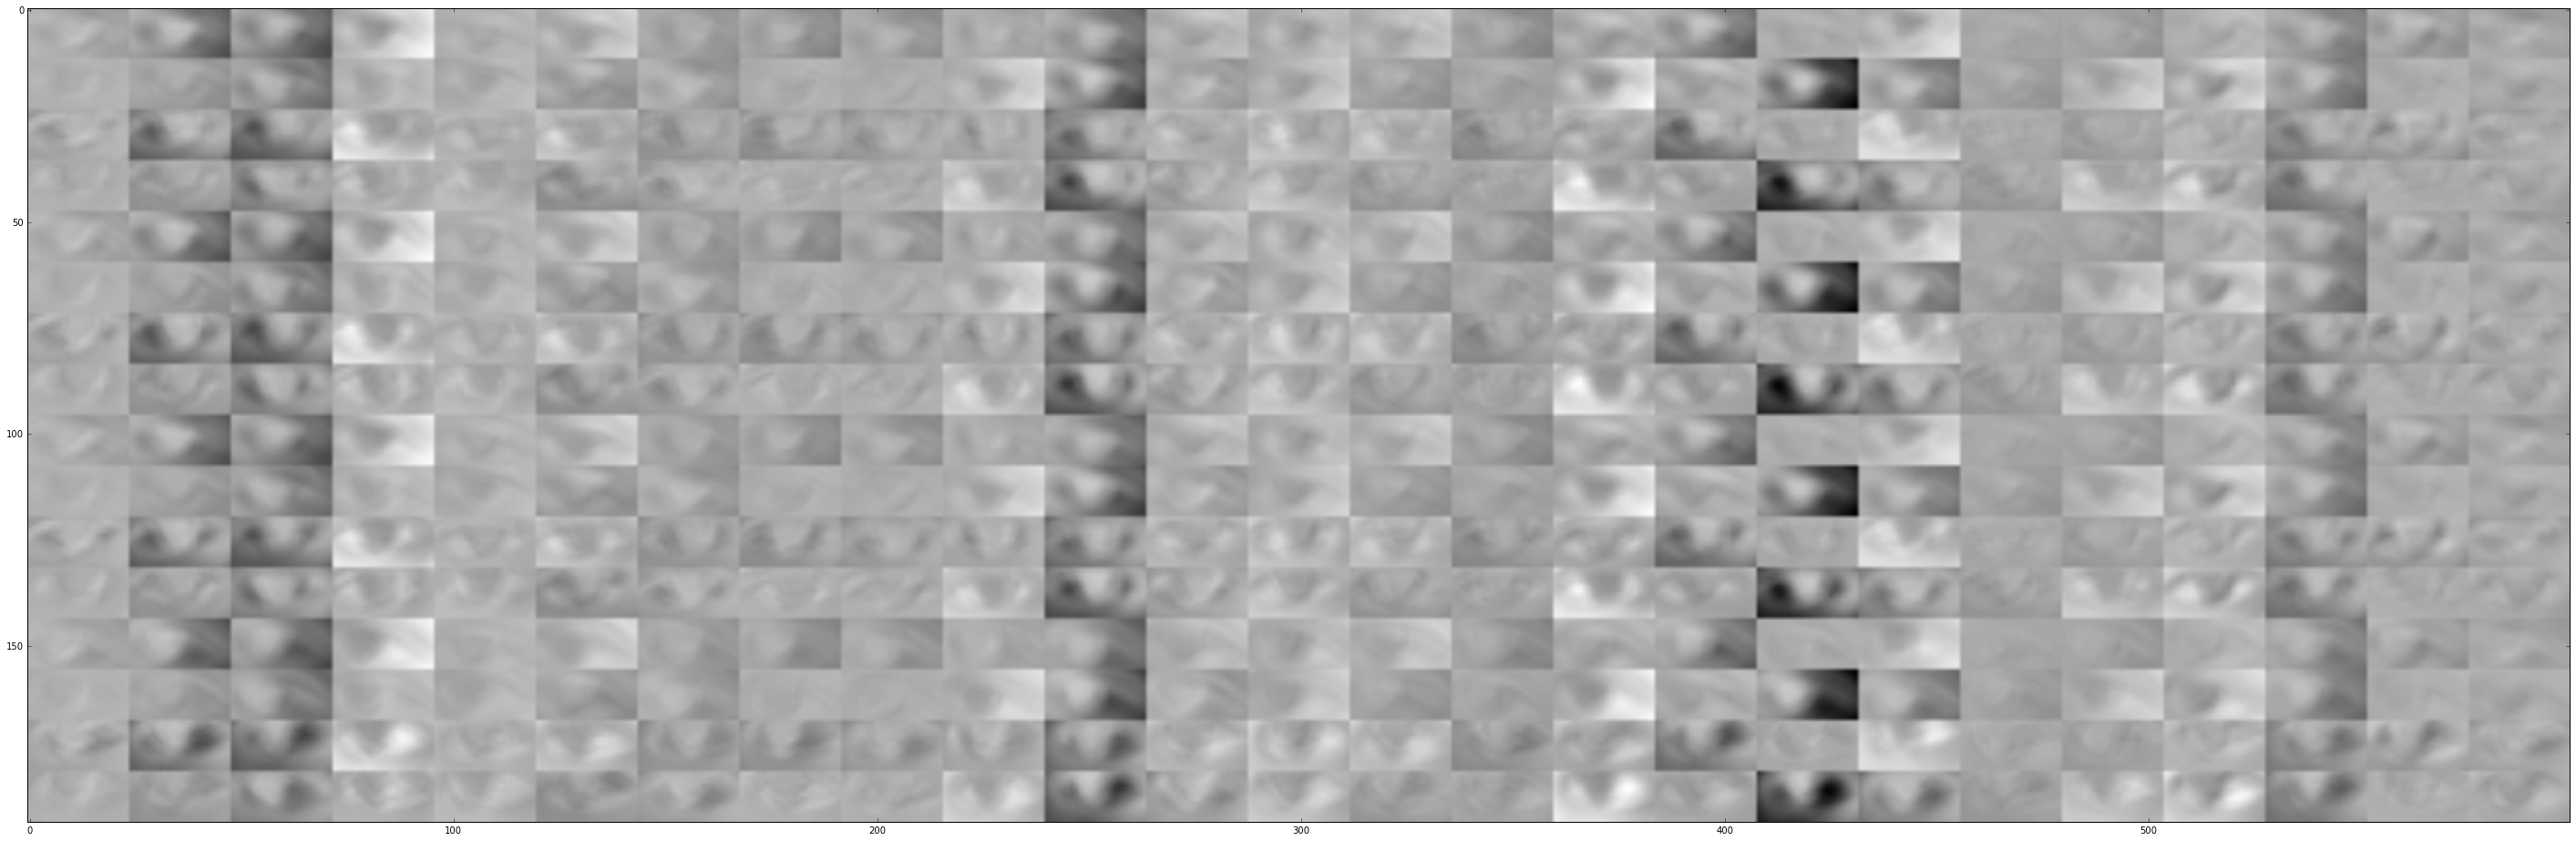

In [14]:
figure(figsize=(50, 25))
imshow(solver.test_nets[0].blobs['conv2'].data[:8, :].reshape(16, 25, 12, 24)
       .transpose(0,2,1,3).reshape(16*12, 25*24), cmap='gray')